# 1. Initializations and Dataset Download

In [1]:
!pip install opendatasets torchsummary --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


# 2. Imports
Import essential libraries for PyTorch deep learning, data processing, and visualization.

In [2]:
import torch # Torch main framework
import torch.nn as nn # Used for getting the NN Layers
from torch.optim import Adam # Adam Optimizer
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creatning the objects
from torchsummary import summary # Visualize the model layers and number of parameters
from sklearn.model_selection import train_test_split # Split the dataset (train, validation, test)
from sklearn.metrics import accuracy_score # Calculate the testing Accuracy
import matplotlib.pyplot as plt # Plotting the training progress at the end
import pandas as pd # Data reading and preprocessing
import numpy as np # Mathematical operations

device = 'cuda' if torch.cuda.is_available() else 'cpu' # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac

# 3. Dataset
Load rice classification dataset, remove null values and ID column for clean training data.

In [3]:
data_df = pd.read_csv("./rice-type-classification/riceClassification.csv") # Read the data
data_df.dropna(inplace = True) # Drop missing/null values
data_df.drop(["id"], axis =1, inplace = True) # Drop Id column
print("Output possibilities: ", data_df["Class"].unique()) # Possible Outputs
print("Data Shape (rows, cols): ", data_df.shape) # Print data shape
data_df.head() # Print/visualize the first 5 rows of the data

Output possibilities:  [1 0]
Data Shape (rows, cols):  (18185, 11)


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


# 4. Data Preprocessing
Normalize all features by dividing by their maximum values to improve model training performance.

In [4]:
original_df = data_df.copy() # Creating a copy of the original Dataframe to use to normalize inference

for column in data_df.columns:
    data_df[column] = data_df[column]/data_df[column].abs().max() # Divide by the maximum of the column which will make max value of each column is 1
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


# 5. Data Splitting
Split dataset into training (70%), validation (15%), and testing (15%) sets for proper model evaluation.

In [5]:
X = np.array(data_df.iloc[:,:-1]) # Get the inputs, all rows and all columns except last column (output)
Y = np.array(data_df.iloc[:, -1]) # Get the ouputs, all rows and last column only (output column)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3) # Create the training split
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5) # Create the validation split

print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/data_df.shape[0],4)*100, "%") # Print training shape
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/data_df.shape[0],4)*100, "%") # Print validation shape
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/data_df.shape[0],4)*100, "%") # Print testing shape

Training set is:  12729  rows which is  70.0 %
Validation set is:  2728  rows which is  15.0 %
Testing set is:  2728  rows which is  15.0 %


# 6. Dataset Object
Create custom PyTorch Dataset class to efficiently handle data loading and tensor conversion.

In [6]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype = torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

# 7. Training Hyperparameters
Set key training parameters: batch size, epochs, hidden neurons, and learning rate.

In [7]:
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_NEURONS = 10
LR = 1e-3

# 8. Data Loaders
Create DataLoader objects for efficient batch processing during training, validation, and testing.

In [8]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)

# 9. Model Class
Define neural network architecture with input layer, hidden layer, and sigmoid activation for binary classification.

In [9]:
class MyModel(nn.Module):
    def __init__(self):

        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

# 10. Model Creation
Initialize the model and move it to GPU/CPU, then display model architecture summary.

In [10]:
model = MyModel().to(device)
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# 11. Loss and Optimizer
Set up Binary Cross Entropy loss function and Adam optimizer for model training.

In [11]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr= LR)

# 12. Training
Execute training loop with forward propagation, backpropagation, and validation monitoring across epochs.

In [12]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    ## Training and Validation
    for data in train_dataloader:

        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ## Validation
    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)

            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)

Epoch no. 1 Train Loss: 0.2465 Train Accuracy: 78.5058 Validation Loss: 0.0426 Validation Accuracy: 97.9106
Epoch no. 2 Train Loss: 0.1328 Train Accuracy: 97.7532 Validation Loss: 0.0183 Validation Accuracy: 97.9472
Epoch no. 3 Train Loss: 0.0592 Train Accuracy: 98.2717 Validation Loss: 0.0099 Validation Accuracy: 98.4238
Epoch no. 4 Train Loss: 0.0362 Train Accuracy: 98.4838 Validation Loss: 0.0072 Validation Accuracy: 98.4238
Epoch no. 5 Train Loss: 0.0274 Train Accuracy: 98.5623 Validation Loss: 0.0059 Validation Accuracy: 98.4971
Epoch no. 6 Train Loss: 0.0230 Train Accuracy: 98.6566 Validation Loss: 0.0053 Validation Accuracy: 98.4238
Epoch no. 7 Train Loss: 0.0205 Train Accuracy: 98.6252 Validation Loss: 0.0049 Validation Accuracy: 98.4238
Epoch no. 8 Train Loss: 0.0190 Train Accuracy: 98.6409 Validation Loss: 0.0048 Validation Accuracy: 98.4238
Epoch no. 9 Train Loss: 0.0180 Train Accuracy: 98.6880 Validation Loss: 0.0047 Validation Accuracy: 98.3138
Epoch no. 10 Train Loss: 0.0

# 13. Testing
Evaluate final model performance on unseen test data and calculate accuracy score.

In [13]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in testing_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion((prediction), labels)
    total_loss_test += batch_loss_test.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 98.57%


# 14. Basic Training Visualization
Plot training and validation loss/accuracy curves to monitor model performance over epochs.

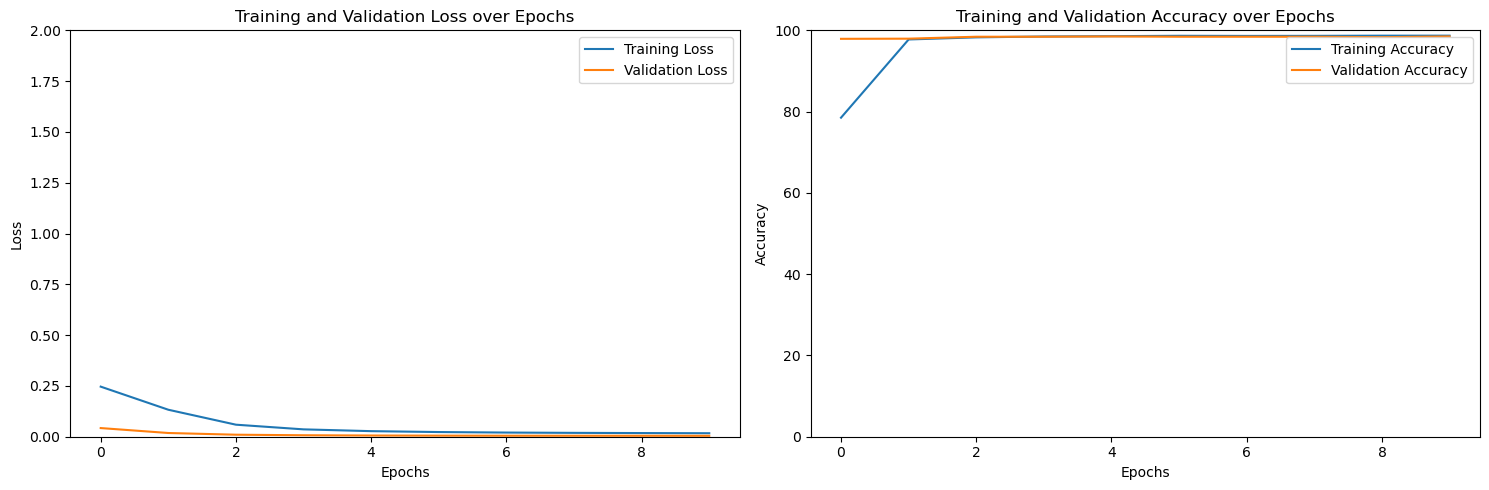

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

# 15. Comprehensive Data Analysis & Visualization
This section generates visualizations and statistical summaries to analyze data distribution, feature importance, model performance, preprocessing effects, and training efficiency in a single comprehensive dashboard.

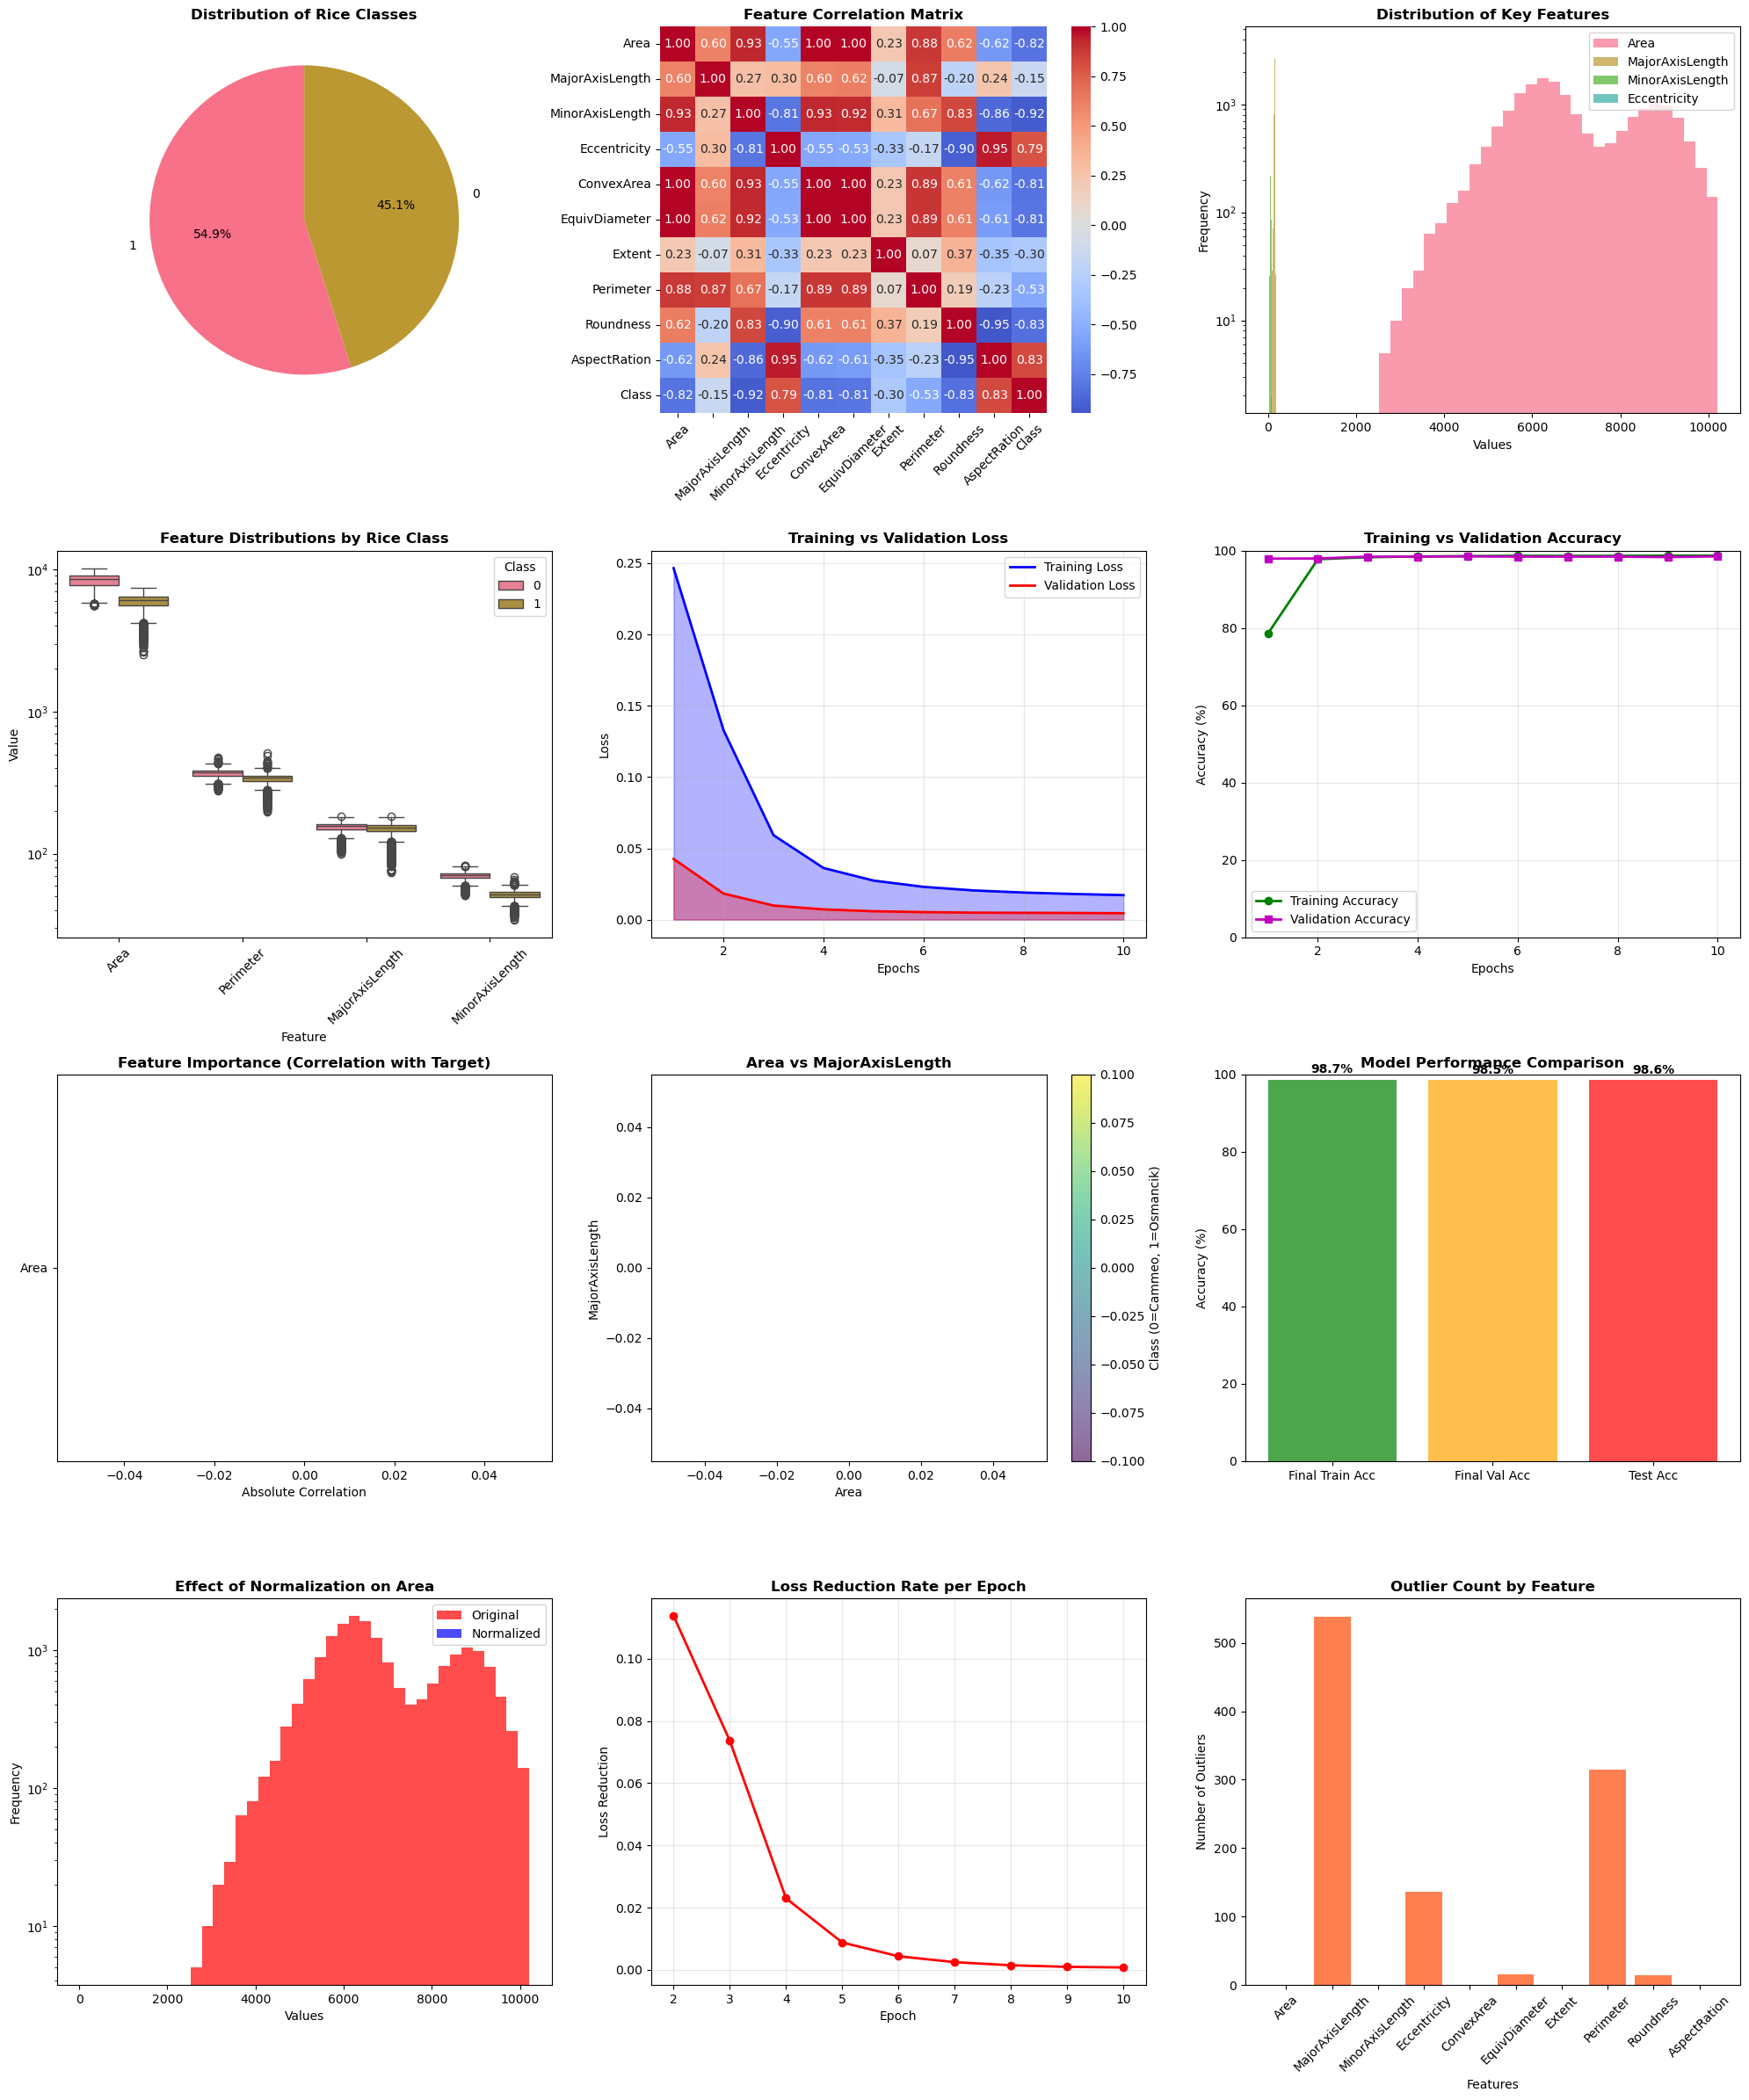

DATA ANALYSIS SUMMARY
Dataset: 18185 samples, 10 features
1: 9985 (54.9%)
0: 8200 (45.1%)
Top Features: Area, MajorAxisLength, MinorAxisLength
Accuracies - Train: 98.7%, Val: 98.5%, Test: 98.6%
Loss improved by 93.0% over 10 epochs


In [15]:
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
fig = plt.figure(figsize=(20, 24))

plt.subplot(4, 3, 1)
class_counts = original_df['Class'].value_counts()
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Rice Classes', fontsize=12, fontweight='bold')

plt.subplot(4, 3, 2)
numeric_df = original_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Feature Correlation Matrix', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.subplot(4, 3, 3)
features = ['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity']
for feature in features:
    plt.hist(original_df[feature], alpha=0.7, label=feature, bins=30)
plt.title('Distribution of Key Features', fontsize=12, fontweight='bold')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.yscale('log')

plt.subplot(4, 3, 4)
key_features = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength']
melted_df = original_df[key_features + ['Class']].melt(id_vars=['Class'], var_name='Feature', value_name='Value')
sns.boxplot(data=melted_df, x='Feature', y='Value', hue='Class')
plt.title('Feature Distributions by Rice Class', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.yscale('log')

plt.subplot(4, 3, 5)
epochs_range = range(1, len(total_loss_train_plot) + 1)
plt.plot(epochs_range, total_loss_train_plot, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_range, total_loss_validation_plot, 'r-', label='Validation Loss', linewidth=2)
plt.fill_between(epochs_range, total_loss_train_plot, alpha=0.3, color='blue')
plt.fill_between(epochs_range, total_loss_validation_plot, alpha=0.3, color='red')
plt.title('Training vs Validation Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(4, 3, 6)
plt.plot(epochs_range, total_acc_train_plot, 'g-', label='Training Accuracy', linewidth=2, marker='o')
plt.plot(epochs_range, total_acc_validation_plot, 'm-', label='Validation Accuracy', linewidth=2, marker='s')
plt.title('Training vs Validation Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0, 100])

plt.subplot(4, 3, 7)
class_numeric = original_df['Class'].map({'Cammeo': 0, 'Osmancik': 1})
feature_importance = {}
for col in numeric_df.columns:
    if col != 'Class':
        corr_coef = abs(numeric_df[col].corr(class_numeric))
        feature_importance[col] = corr_coef

sorted_features = dict(sorted(feature_importance.items(), key=lambda x: x[1], reverse=True))
plt.barh(list(sorted_features.keys()), list(sorted_features.values()), color='skyblue')
plt.title('Feature Importance (Correlation with Target)', fontsize=12, fontweight='bold')
plt.xlabel('Absolute Correlation')

plt.subplot(4, 3, 8)
top_features = list(sorted_features.keys())[:2]
if len(top_features) >= 2:
    scatter = plt.scatter(original_df[top_features[0]], original_df[top_features[1]], 
                         c=class_numeric, cmap='viridis', alpha=0.6)
    plt.xlabel(top_features[0])
    plt.ylabel(top_features[1])
    plt.title(f'{top_features[0]} vs {top_features[1]}', fontsize=12, fontweight='bold')
    plt.colorbar(scatter, label='Class (0=Cammeo, 1=Osmancik)')

plt.subplot(4, 3, 9)
metrics = ['Final Train Acc', 'Final Val Acc', 'Test Acc']
values = [total_acc_train_plot[-1], total_acc_validation_plot[-1], 
          round((total_acc_test/X_test.shape[0])*100, 2)]
colors = ['green', 'orange', 'red']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title('Model Performance Comparison', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.subplot(4, 3, 10)
sample_feature = 'Area'
plt.hist(original_df[sample_feature], alpha=0.7, label='Original', bins=30, color='red')
plt.hist(data_df[sample_feature], alpha=0.7, label='Normalized', bins=30, color='blue')
plt.title(f'Effect of Normalization on {sample_feature}', fontsize=12, fontweight='bold')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.yscale('log')

plt.subplot(4, 3, 11)
loss_reduction = []
for i in range(1, len(total_loss_train_plot)):
    reduction = total_loss_train_plot[i-1] - total_loss_train_plot[i]
    loss_reduction.append(reduction)

plt.plot(range(2, len(total_loss_train_plot) + 1), loss_reduction, 'ro-', linewidth=2)
plt.title('Loss Reduction Rate per Epoch', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss Reduction')
plt.grid(True, alpha=0.3)

plt.subplot(4, 3, 12)
outlier_counts = {}
for col in numeric_df.columns:
    if col != 'Class':
        Q1 = original_df[col].quantile(0.25)
        Q3 = original_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = original_df[(original_df[col] < lower_bound) | (original_df[col] > upper_bound)]
        outlier_counts[col] = len(outliers)

plt.bar(range(len(outlier_counts)), list(outlier_counts.values()), color='coral')
plt.title('Outlier Count by Feature', fontsize=12, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Number of Outliers')
plt.xticks(range(len(outlier_counts)), list(outlier_counts.keys()), rotation=45)

plt.tight_layout()
plt.show()

print("="*60)
print("DATA ANALYSIS SUMMARY")
print("="*60)
print(f"Dataset: {original_df.shape[0]} samples, {len(numeric_df.columns)-1} features")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} ({count/len(original_df)*100:.1f}%)")
print(f"Top Features: {', '.join(list(sorted_features.keys())[:3])}")
print(f"Accuracies - Train: {total_acc_train_plot[-1]:.1f}%, Val: {total_acc_validation_plot[-1]:.1f}%, Test: {(total_acc_test/X_test.shape[0])*100:.1f}%")
initial_loss = total_loss_train_plot[0]
final_loss = total_loss_train_plot[-1]
print(f"Loss improved by {((initial_loss-final_loss)/initial_loss)*100:.1f}% over {len(total_loss_train_plot)} epochs")
print("="*60)

# 16. Inference
Real-time model predictions with user input normalization for production-ready rice classification.

In [16]:
area = float(input("Area: "))/original_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))

Area:  6431.279
Major Axis Length:  145.21338
Minor Axis Length:  56.902
Eccentricity:  0.919981821
Convex Area:  6518.93759999
EquivDiameter:  90.483541
Extent:  0.8506668
Perimeter:  329.972
Roundness:  0.742255516
AspectRation:  2.551696


tensor([0.8514], grad_fn=<SigmoidBackward0>)
Class is:  1
